In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering

In [2]:
customer_df = pd.read_csv('Online Retail.csv')
customer_df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [81]:
customer_df.shape

(541909, 9)

In [3]:
customer_df.drop('index', axis=1, inplace=True)

In [4]:
customer_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
customer_df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
customer_df.dropna(inplace=True)

In [7]:
customer_df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
customer_df.shape

(406829, 8)

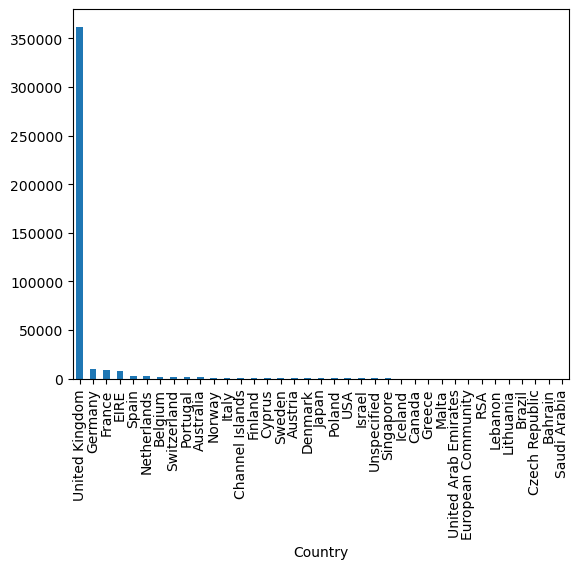

In [11]:
customer_df['Country'].value_counts().plot(kind='bar')
plt.show()

Most of the customers are from UK.

In [54]:
customer_df_cp = customer_df.copy()

In [55]:
customer_df_cp['InvoiceDate'] = pd.to_datetime(customer_df_cp['InvoiceDate'])

In [58]:
customer_df_cp['Month'] = customer_df_cp['InvoiceDate'].dt.strftime('%b')


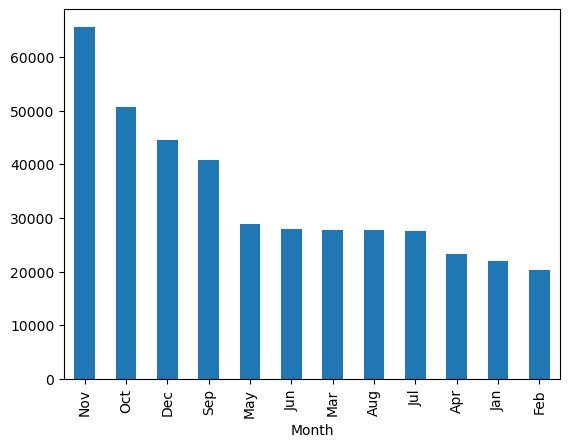

In [59]:
customer_df_cp['Month'].value_counts().plot(kind='bar')
plt.show()

September to December i.e winter season has seen maximum traffic whereas Febraury has the least.

In [60]:
customer_df_cp['hours'] = customer_df_cp['InvoiceDate'].dt.hour

In [61]:
hour_bins = pd.cut(customer_df_cp['hours'], bins=[i for i in range(1, 25)], right=False, labels=[f'{i}:00-{i+1}:00' for i in range(1, 24)])

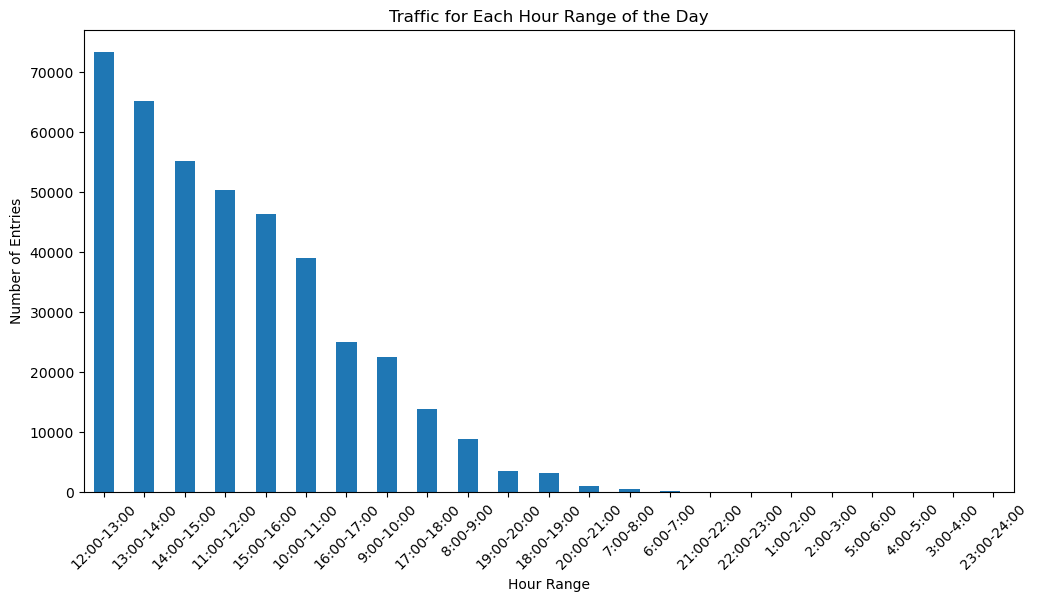

In [62]:
hourly_traffic = hour_bins.value_counts()


plt.figure(figsize=(12, 6))
hourly_traffic.plot(kind='bar')
plt.title('Traffic for Each Hour Range of the Day')
plt.xlabel('Hour Range')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.show()

Maximun traffic occurs between 12 to 1, and then 1 to 2 and then 2 to 3 pm, while minimum sales occur between 6 to 7 am.Where as no sales occur between 9 pm to 6 am.

<Figure size 2400x800 with 0 Axes>

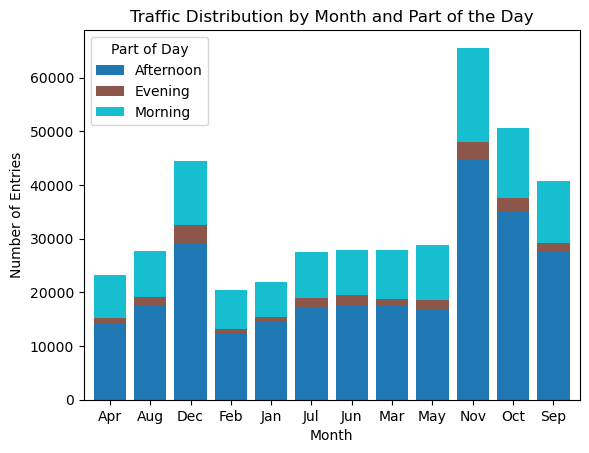

In [63]:
def get_part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

customer_df_cp['part_of_day'] = customer_df_cp['hours'].apply(get_part_of_day)

traffic_summary = customer_df_cp.groupby(['Month', 'part_of_day']).size().unstack().fillna(0)

# Plotting the traffic data
plt.figure(figsize=(24, 8))
traffic_summary.plot(kind='bar', stacked=True, colormap='tab10', width=0.8)
plt.title('Traffic Distribution by Month and Part of the Day')
plt.xlabel('Month')
plt.ylabel('Number of Entries')
plt.xticks(rotation=0)
plt.legend(title='Part of Day')
plt.show()

November Afternoon has maximum traffic, followed by October, September and December Afternoons.

In [45]:
customer_df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [8]:
customer_df['TotalSpent'] = customer_df['Quantity'] * customer_df['UnitPrice']

In [9]:
customer_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [10]:
customer_df['InvoiceDate'] = pd.to_datetime(customer_df['InvoiceDate'])

In [69]:
customer_df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [11]:
# Ensure snapshot_date remains a datetime object
snapshot_date = customer_df['InvoiceDate'].max() + dt.timedelta(days=1)

# Calculate RFM values
rfm = customer_df.groupby(['CustomerID', 'Country']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  
    'InvoiceNo': 'count',                                    
    'TotalSpent': 'sum'                                      
}).reset_index()
rfm.head()

,CustomerID,Country,InvoiceDate,InvoiceNo,TotalSpent
0,12346.0,United Kingdom,326,2,0.00
1,12347.0,Iceland,2,182,4310.00
2,12348.0,Finland,75,31,1797.24
3,12349.0,Italy,19,73,1757.55
4,12350.0,Norway,310,17,334.40


In [12]:
label_encoder = LabelEncoder()
rfm['Country'] = label_encoder.fit_transform(rfm['Country'])

In [13]:
rfm.head()

,CustomerID,Country,InvoiceDate,InvoiceNo,TotalSpent
0,12346.0,35,326,2,0.00
1,12347.0,16,2,182,4310.00
2,12348.0,12,75,31,1797.24
3,12349.0,18,19,73,1757.55
4,12350.0,24,310,17,334.40


In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm)

In [15]:
cluster_analysis = rfm.groupby('Cluster').mean()

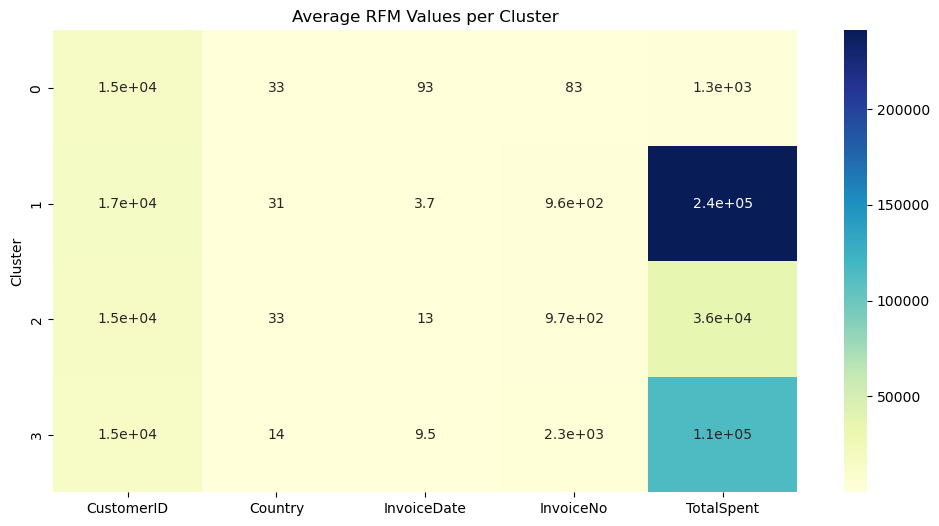

In [16]:
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_analysis, annot=True, cmap="YlGnBu")
plt.title('Average RFM Values per Cluster')
plt.show()

In [18]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm, kmeans.labels_))

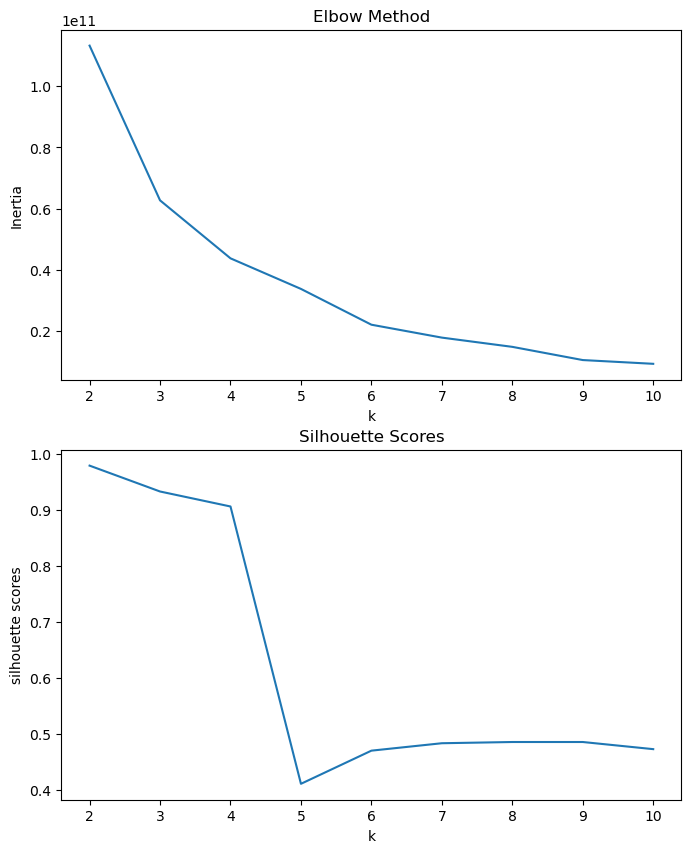

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
axes = axes.flatten()
axes[0].plot(k_range, inertias)
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[1].plot(k_range, silhouette_scores)
axes[1].set_title('Silhouette Scores')
axes[1].set_xlabel('k')
axes[1].set_ylabel('silhouette scores')

plt.show()

# Hierarchical Clustring

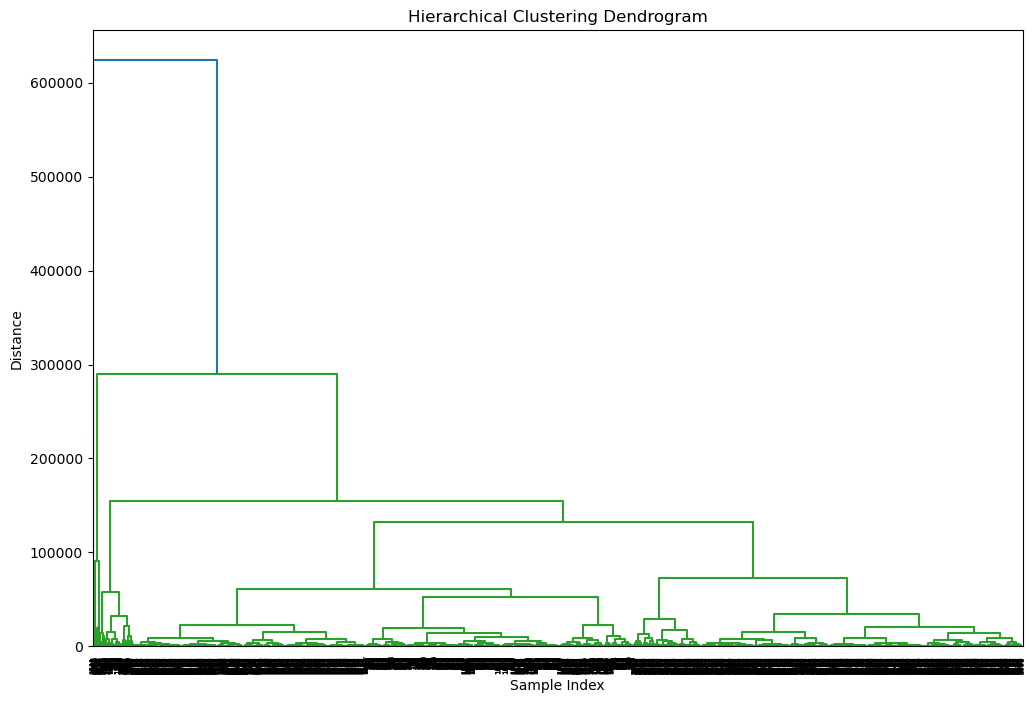

In [20]:
linkage_matrix = linkage(rfm, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [22]:
max_d = 5 
clusters_hierarchical = fcluster(linkage_matrix, max_d, criterion='maxclust')

rfm['cluster_hierarchical'] = clusters_hierarchical

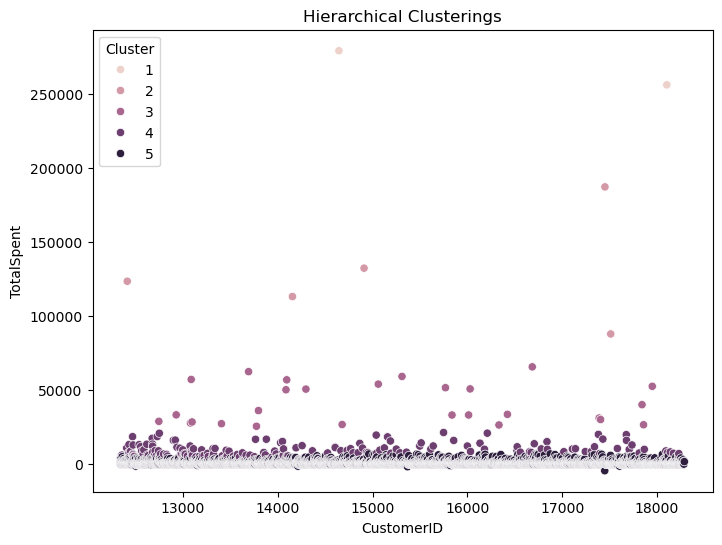

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='CustomerID', y='TotalSpent', hue='cluster_hierarchical', data=rfm)
plt.title('Hierarchical Clusterings')
plt.xlabel('CustomerID')
plt.ylabel('TotalSpent')
plt.legend(title='Cluster')
plt.show()

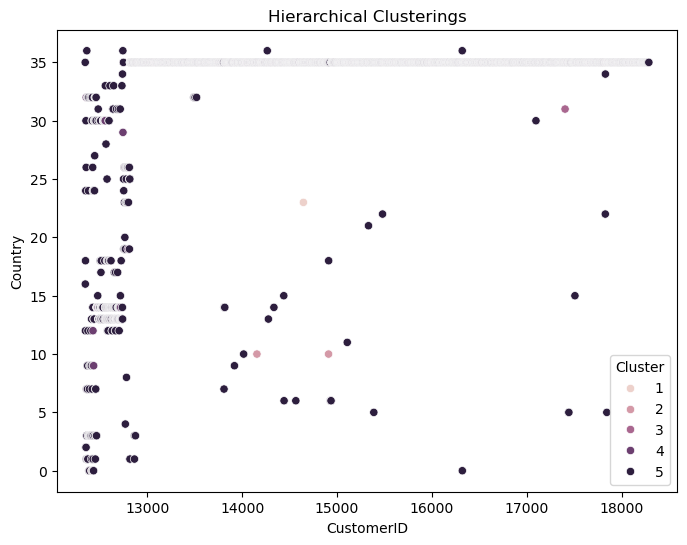

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='CustomerID', y='Country', hue='cluster_hierarchical', data=rfm)
plt.title('Hierarchical Clusterings')
plt.xlabel('CustomerID')
plt.ylabel('Country')
plt.legend(title='Cluster')
plt.show()

In [30]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(rfm)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=features_pca, columns=['PCA1', 'PCA2'])
pca_df['cluster_hierarchical'] = clusters_hierarchical
pca_df['cluster_kmeans'] = clusters_kmeans
     

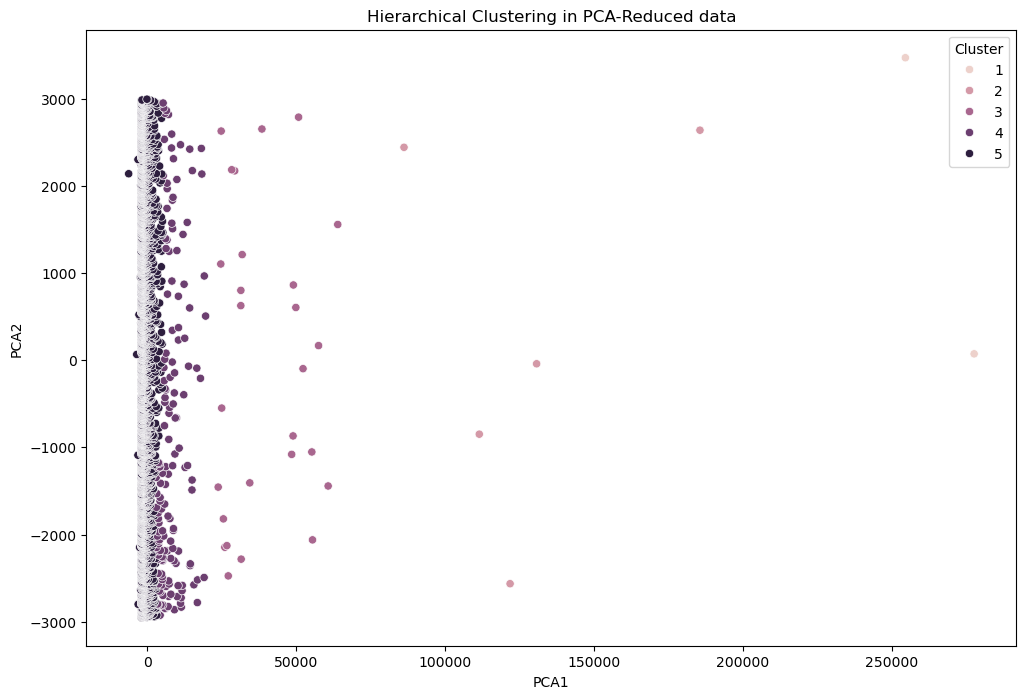

In [31]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_hierarchical', data=pca_df)
plt.title('Hierarchical Clustering in PCA-Reduced data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()